In [1]:
from danial import f3, pre_fcs, fcs, vgg, spg, prm, dataloader
import torch

In [2]:
test = dataloader.load_image("test-images/camo-tank.png", target_size = (224,224))

In [28]:
#t to simulate batch size
batch_size = 1
test = torch.rand(batch_size, 3, 224, 224) # batch 8, rgb image 224 by 224

In [3]:
VGG = vgg.backbone()


spg_module = spg.SPGWithFPN(in_channels1=64, in_channels2=256)

f3_module = f3.F3Conv(in_channels=256, out_channels=128)

prm_module = prm.PRM(f3_channels=128, spg_channels=256, fused_channels=128)

pre_crfcs = pre_fcs.PreFCS()

crfcs = fcs.CRFCS(roi_channels=64, boundary_channels=64)


/Users/dania/code/fyp/MHNet/vengeance/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/dania/code/fyp/MHNet/vengeance/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
features = VGG(test, return_all=True)
for items in features:
    print(features[items].shape)

torch.Size([1, 64, 112, 112])
torch.Size([1, 128, 56, 56])
torch.Size([1, 256, 28, 28])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 7, 7])


In [5]:
spg_out = spg_module(features['block1'], features['block3'])
print("SPG output shape:", spg_out.shape)

SPG output shape: torch.Size([1, 256, 112, 112])


In [6]:
f3_out = f3_module(features['block3'])

print(f3_out.shape)


torch.Size([1, 128, 28, 28])


In [7]:
prm_out = prm_module(f3_out, spg_out)
print(prm_out.shape)

torch.Size([1, 8, 8, 56, 56])


In [8]:
ROI = pre_crfcs(f3_out,prm_out)
branch = pre_crfcs.branch
print(ROI.shape)
print(branch.shape)

torch.Size([1, 64, 7, 7])
torch.Size([1, 64, 56, 56])


In [9]:
cls_out, reg_out, recovered, mask = crfcs(ROI, branch)
print(cls_out.shape)
print(reg_out.shape)
print(mask.shape)

torch.Size([1, 5])
torch.Size([1, 4])
torch.Size([1, 1, 224, 224])


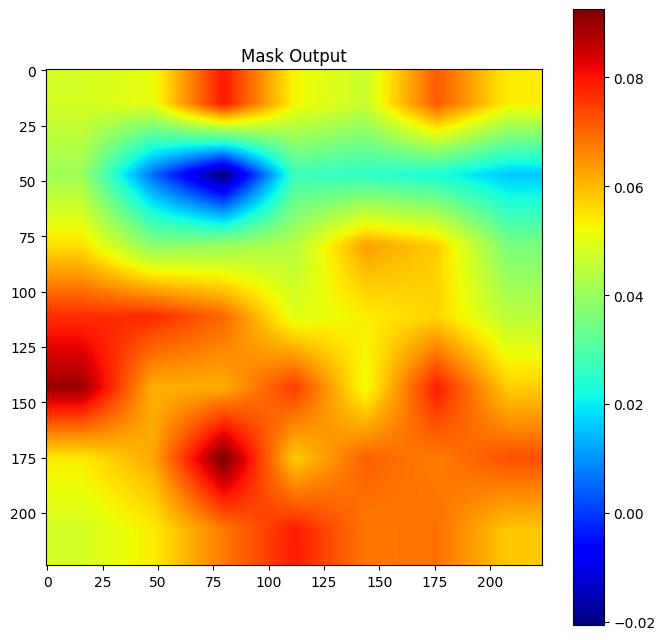

In [10]:
import matplotlib.pyplot as plt

# Convert the mask tensor to numpy array and remove extra dimensions
mask_np = mask.detach().squeeze().numpy()  # removes batch and channel dimensions

# Create a figure
plt.figure(figsize=(8, 8))
plt.imshow(mask_np, cmap='jet')
plt.colorbar()
plt.title('Mask Output')
plt.axis('on')
plt.show()